# Sonification, epilepsy real data, and quantum simulation of the dataset

In [90]:
# taking only one line of .txt file each N ones:

In [91]:
from pathlib import Path

def list_filenames(folder_path):
    """
    Returns a list of file names (not directories) in the given folder.
    """
    folder = Path(folder_path)
    return [folder_path + p.name for p in folder.iterdir() if p.is_file()]


In [3]:
import numpy as np
from scipy.io.wavfile import write

def generate_wave(pitches, note_duration=0.33, sample_rate=44100):
    """Generate a waveform based on a list of pitches (frequencies)."""
    waveform = np.array([], dtype=np.float32)

    for freq in pitches:
        t = np.linspace(0, note_duration, int(sample_rate * note_duration), endpoint=False)
        wave = 0.5 * np.sin(2 * np.pi * freq * t)  # sine wave generation
        waveform = np.concatenate((waveform, wave))
    
    return waveform

def load_time_series(filename, step = 500): # N = 1000
    """Load every `step`-th line from a time series file."""
    times = []
    values = []
    
    with open(filename, 'r') as f:
        for i, line in enumerate(f):
            if i % step == 0:  # Keep only every 50th line
                try:
                    time, value = map(float, line.strip().split())
                    times.append(time)
                    values.append(value)
                except ValueError:
                    continue  # Skip malformed lines
    
    return np.array(times), np.array(values)



def sonify_files(file_paths):
    """Sonify multiple time series by loading them and generating waveforms."""
    all_waveforms = []

    for file_path in file_paths:
        times, values = load_time_series(file_path)
        
        # Map values to frequencies (C4 to B5)
        
        # 493.88
        # 1244.51
        
        min_freq, max_freq = 261.63, 1244.51  # C4 to B5 frequency range
        v_min, v_max = min(values), max(values)  # Find the min and max values in the dataset
        normalized = [(v - v_min) / (v_max - v_min) for v in values]  # Normalize the values to a 0-1 scale
        frequencies = [min_freq + n * (max_freq - min_freq) for n in normalized]  # Map to pitch values
        
        # Generate the waveform for the sonified data (based on the frequencies)
        waveform = generate_wave(frequencies, note_duration = 0.1) # modified
        
        # Append the waveform to the list
        all_waveforms.append(waveform)
    
    # Combine the waveforms (by summing them to create a stereo effect or a simple mix)
    max_length = max(len(waveform) for waveform in all_waveforms)
    
    # Pad shorter waveforms with zeros to match the length of the longest one
    for i in range(len(all_waveforms)):
        if len(all_waveforms[i]) < max_length:
            all_waveforms[i] = np.pad(all_waveforms[i], (0, max_length - len(all_waveforms[i])), 'constant')
    
    # Sum all waveforms to mix them together
    combined_waveform = np.sum(all_waveforms, axis=0)
    
    # Normalize the combined waveform to prevent clipping
    combined_waveform = combined_waveform / np.max(np.abs(combined_waveform))
    
    return combined_waveform




In [14]:
patientID = 2

datapath = f'channels_for_sonification/patient{patientID}/'

file_paths = list_filenames(datapath)
print(file_paths)

# Generate and combine waveforms from the files
combined_waveform = sonify_files(file_paths)

# Output file path for the saved .wav file
output_file = f"output/patient{patientID}_combined_sonification_NOFM.wav"

# Save the combined waveform as a 16-bit WAV file
write(output_file, 44100, (combined_waveform * 32767).astype(np.int16))  # Scale to 16-bit PCM format

print(f"Saved combined melody as a wav file to {output_file}")

['channels_for_sonification/patient2/LALT4_no_first.txt', 'channels_for_sonification/patient2/LAST3_no_first.txt', 'channels_for_sonification/patient2/LALT5_no_first.txt', 'channels_for_sonification/patient2/LALT3_no_first.txt', 'channels_for_sonification/patient2/LAST2_no_first.txt']
Saved combined melody as a wav file to output/patient2_combined_sonification_NOFM.wav


In [5]:
# low-pass filter

In [6]:
from scipy.signal import butter, lfilter

In [7]:
import numpy as np
from scipy.io.wavfile import read, write
from scipy.signal import butter, lfilter, medfilt
import matplotlib.pyplot as plt

def lowpass_filter(data, cutoff=2000, sample_rate=44100, order=5):
    """Apply a low-pass Butterworth filter."""
    nyquist = 0.5 * sample_rate
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return lfilter(b, a, data)

def remove_clicks(audio_data, kernel_size=7):
    """Apply a median filter to remove sharp transient clicks."""
    return medfilt(audio_data, kernel_size=kernel_size)

def process_audio(input_path, output_path, cutoff = 2000, kernel_size = 10):
    # Load the WAV file
    sample_rate, data = read(input_file)

    # If stereo, take only one channel
    if data.ndim > 1:
        data = data[:, 0]

    # Normalize if in int16 format
    if data.dtype == np.int16:
        data = data.astype(np.float32) / 32767.0

    # Step 1: Low-pass filter
    filtered = lowpass_filter(data, cutoff=cutoff, sample_rate=sample_rate)

    # Step 2: Click removal via median filtering
    cleaned = remove_clicks(filtered, kernel_size=kernel_size)

    # Normalize output to avoid clipping
    cleaned = cleaned / np.max(np.abs(cleaned))

    # Save the result
    write(output_file, sample_rate, (cleaned * 32767).astype(np.int16))
    
    

In [15]:
input_file = f"output/patient{patientID}_combined_sonification_NOFM.wav"
output_file = f"output/patient{patientID}_combined_filtered_and_declicked_NOFM.wav"



# process_audio(input_file, output_file, cutoff = 2000, kernel_size=7)


In [89]:
# import matplotlib.pyplot as plt
# from scipy.io import wavfile

# def plot_spectrogram(title, wav_path):
#     """Plot a spectrogram of the given WAV file."""
#     sample_rate, data = wavfile.read(wav_path)
    
#     # If stereo, take only one channel
#     if data.ndim > 1:
#         data = data[:, 0]
    
#     plt.figure(figsize=(12, 6))
#     plt.specgram(data, Fs=sample_rate, NFFT=1024, noverlap=512, cmap='inferno')
#     #plt.title("Spectrogram")
#     plt.title(title)
#     plt.xlabel("Time (s)")
#     plt.ylabel("Frequency (Hz)")
#     plt.colorbar(label="Intensity (dB)")
#     plt.tight_layout()
#     #plt.savefig("/Users/mariamannone/Desktop/new_phd_/sonification_test_epilepsy_/{title}.pdf", format="pdf", bbox_inches="tight")
#     plt.savefig(f"output/{title}.pdf", format="pdf", bbox_inches="tight")
#     plt.show()

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile


def plot_spectrogram(
    title,
    wav_path,
    savefig=None,
    nfft=2048,
    noverlap=1536,
    cmap="cividis",
    db_floor=-90
):
    """
    Paper-style spectrogram plot with viridis colormap.
    Uses log-scaled power in dB with a clean dynamic range.
    """

    plt.rcParams.update({
        "font.family": "serif",
        "mathtext.fontset": "cm",
        "font.size": 22,
        "axes.labelsize": 22,
        "axes.titlesize": 22,
        "xtick.labelsize": 18,
        "ytick.labelsize": 18,
        "axes.linewidth": 1.2
    })

    sample_rate, data = wavfile.read(wav_path)

    # convert stereo -> mono
    if data.ndim > 1:
        data = data[:, 0]

    # normalize if integer wav
    if np.issubdtype(data.dtype, np.integer):
        data = data.astype(np.float32) / np.iinfo(data.dtype).max
    else:
        data = data.astype(np.float32)

    fig, ax = plt.subplots(figsize=(12, 5.5))

    # spectrogram returns:
    # Pxx: power spectral density
    # freqs: frequency bins
    # bins: time bins
    # im: AxesImage
    Pxx, freqs, bins, im = ax.specgram(
        data,
        Fs=sample_rate,
        NFFT=nfft,
        noverlap=noverlap,
        cmap=cmap,
        scale="dB",
        mode="psd"
    )

    # Set dynamic range (avoid washed-out plot)
    vmax = np.max(10 * np.log10(Pxx + 1e-12))
    vmin = vmax + db_floor
    im.set_clim(vmin, vmax)

    ax.set_title(title)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Frequency (Hz)")

    # cleaner grid (very subtle)
    ax.grid(False)

    # colorbar
    cbar = fig.colorbar(im, ax=ax, pad=0.02)
    cbar.set_label("Power (dB)", rotation=270, labelpad=18)

    plt.tight_layout()

    if savefig is not None:
        plt.savefig(savefig, format="pdf", bbox_inches="tight")

    plt.show()


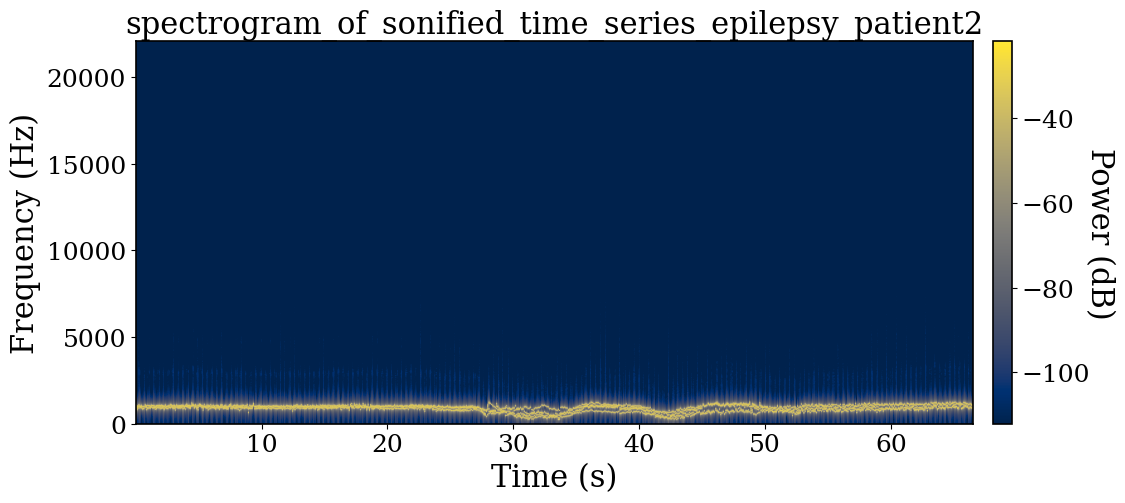

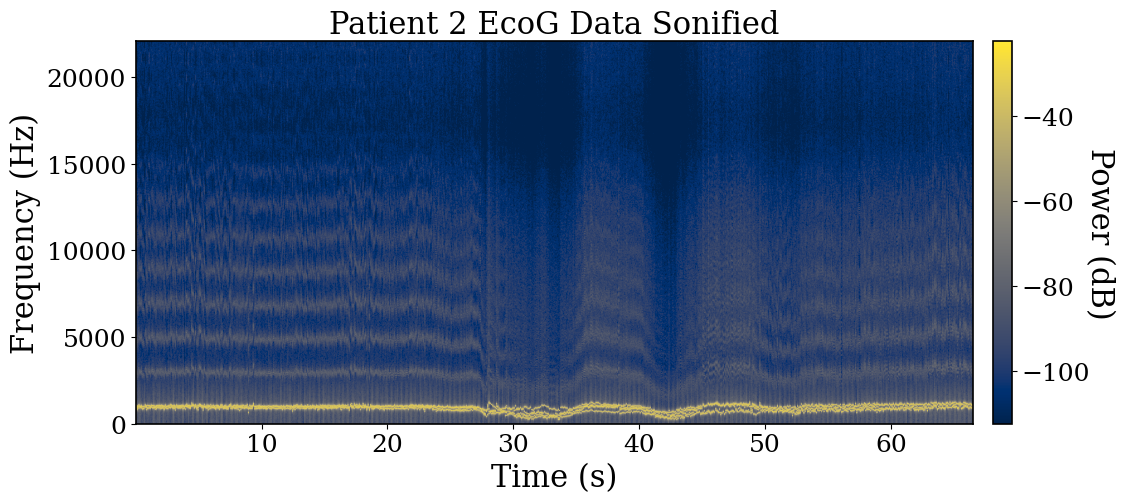

In [16]:
plot_spectrogram(f"spectrogram_of_sonified_time_series_epilepsy_patient{patientID}", input_file)
plot_spectrogram(f"Patient {patientID} EcoG Data Sonified", output_file, savefig=f"spectrogram_of_sonified_and_filtered_time_series_epilepsy_patient{patientID}_cividis.pdf")


In [82]:
def sonify_files(file_paths):
    """Sonify multiple time series by loading them and generating waveforms."""
    all_waveforms = []

    for file_path in file_paths:
        times, values = load_time_series(file_path)
        
        # Map values to frequencies (C4 to B5)
        
        # 493.88
        # 1244.51
        
        min_freq, max_freq = 261.63, 1244.51  # C4 to B5 frequency range
        v_min, v_max = min(values), max(values)  # Find the min and max values in the dataset
        normalized = [(v - v_min) / (v_max - v_min) for v in values]  # Normalize the values to a 0-1 scale
        frequencies = [min_freq + n * (max_freq - min_freq) for n in normalized]  # Map to pitch values
        
        # Generate the waveform for the sonified data (based on the frequencies)
        waveform = generate_wave(frequencies, note_duration = 0.065) # modified # from 0.1 to 0.9
        
        # Append the waveform to the list
        all_waveforms.append(waveform)
    
    # Combine the waveforms (by summing them to create a stereo effect or a simple mix)
    max_length = max(len(waveform) for waveform in all_waveforms)
    
    # Pad shorter waveforms with zeros to match the length of the longest one
    for i in range(len(all_waveforms)):
        if len(all_waveforms[i]) < max_length:
            all_waveforms[i] = np.pad(all_waveforms[i], (0, max_length - len(all_waveforms[i])), 'constant')
    
    # Sum all waveforms to mix them together
    combined_waveform = np.sum(all_waveforms, axis=0)
    
    # Normalize the combined waveform to prevent clipping
    combined_waveform = combined_waveform / np.max(np.abs(combined_waveform))
    
    return combined_waveform

if __name__ == "__main__":
    # File paths of the time series data
    file_paths = [
        # complete .txt files, but where I removed the first line
        "computed_sonification_data/patient1_quantum_rolling_a4_MST4.txt"
    ]
    
   
    # Generate and combine waveforms from the files
    combined_waveform = sonify_files(file_paths)
    
    # Output file path for the saved .wav file
    output_path = "output/sonification_quantum_from_MST4_.wav"
    
    # Save the combined waveform as a 16-bit WAV file
    write(output_path, 44100, (combined_waveform * 32767).astype(np.int16))  # Scale to 16-bit PCM format
    
    print(f"Saved combined melody as a wav file to {output_path}")


Saved combined melody as a wav file to output/sonification_quantum_from_MST4_.wav


In [83]:
input_file = "output/sonification_quantum_from_MST4_.wav"
output_file = "output/sonification_quantum_from_MST4_modified.wav"

process_audio(input_file, output_file, cutoff = 2000, kernel_size=7)

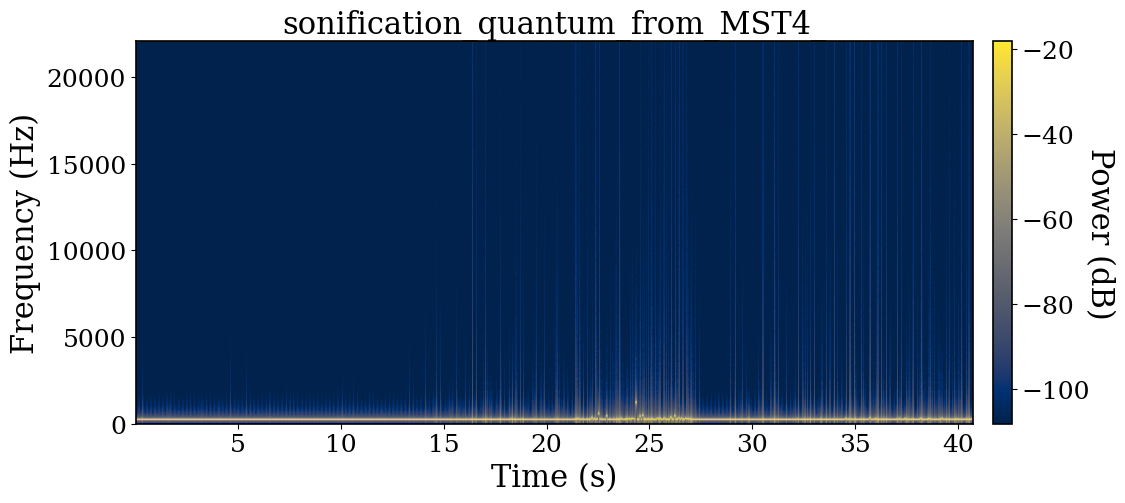

In [88]:
plot_spectrogram("sonification_quantum_from_MST4_", "output/sonification_quantum_from_MST4_.wav", savefig='output/patient1_sonification_quantum_from_MST4_.pdf')
                 
